GB Model:

5 parts

The first part contains the imports

The second part is the main code which actually contains the GB function and runs the MCCV loop (set to 200 iterations with 90/10 train test) but can be changed via n_splits and test_fraction

The third part is the predicted versus actual plot 

The fourth part is the prediction part which contains the GB prediction of the 4851 dataset of different molecules

The fifth part is optional and it removes all the molecules that were in the training set from the large predicted set (to avoid artifically better results)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


In [2]:

data = pd.read_csv("data.csv")


numeric_features = ['ionic_character_2nd_root', 'Diff_Ionic_4th_root','Sum_Affinity','Prod_Ionic_Recip']
categorical_features = ['Group1', 'Group2', 'Period1', 'Period2']
target = 'dipole_moment'
molecule_column = 'Molecule' ##For Grouping##

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features), 
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

X = preprocessor.fit_transform(data[numeric_features + categorical_features])
y = data[target].values.flatten()
molecules = data[molecule_column].values

# --- MCCV Parameters ---
n_splits = 200
test_fraction = 0.1

# --- Aggregation ---
all_predictions_test = {}
all_predictions_train = {}
rmse_train_values = []
rmse_test_values = []
mae_train_values = []
mae_test_values = []
per_sample_test_errors = {}
per_sample_train_errors = {}

unique_molecules = np.unique(molecules)
n_total_unique_molecules = len(unique_molecules)
n_test_molecules = int(test_fraction * n_total_unique_molecules)
n_train_molecules = n_total_unique_molecules - n_test_molecules

true_iteration = 0
attempt = 0
max_attempts = 10000

while true_iteration < n_splits and attempt < max_attempts:
    attempt += 1
    test_molecules_sample = np.random.choice(unique_molecules, size=n_test_molecules, replace=False)
    train_molecules_sample = np.setdiff1d(unique_molecules, test_molecules_sample)

    train_index = np.where(np.isin(molecules, train_molecules_sample))[0]
    test_index = np.where(np.isin(molecules, test_molecules_sample))[0]

    if len(test_index) == 0 or len(train_index) == 0:
        continue

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = HistGradientBoostingRegressor(max_iter=1000)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    for j, idx in enumerate(test_index):
        all_predictions_test.setdefault(idx, []).append(y_test_pred[j])
        per_sample_test_errors[idx] = per_sample_test_errors.get(idx, []) + [(y[idx] - y_test_pred[j])**2]

    for j, idx in enumerate(train_index):
        all_predictions_train.setdefault(idx, []).append(y_train_pred[j])
        per_sample_train_errors[idx] = per_sample_train_errors.get(idx, []) + [(y[idx] - y_train_pred[j])**2]

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    rmse_train_values.append(rmse_train)
    rmse_test_values.append(rmse_test)
    mae_train_values.append(mae_train)
    mae_test_values.append(mae_test)

    true_iteration += 1
    if true_iteration % 10 == 0 or true_iteration == 1:
        print(f"Iteration {true_iteration}/{n_splits} (attempt {attempt}) - "
              f"RMSE Train: {rmse_train:.4f}, RMSE Test: {rmse_test:.4f}, "
              f"MAE Train: {mae_train:.4f}, MAE Test: {mae_test:.4f}")

if true_iteration < n_splits:
    print(f"Warning: Only {true_iteration} of {n_splits} iterations completed.")

# --- Final evaluation ---
final_rmse_test = np.sqrt(np.mean([np.mean(sq) for sq in per_sample_test_errors.values()]))
final_rmse_train = np.sqrt(np.mean([np.mean(sq) for sq in per_sample_train_errors.values()]))

print("--- FINAL RESULTS ---")
print(f"Overall Avg Train RMSE: {np.mean(rmse_train_values):.4f}")
print(f"Overall Avg Test RMSE: {np.mean(rmse_test_values):.4f}")
print(f"Train RMSE Std Dev: {np.std(rmse_train_values):.4f}")
print(f"Test RMSE Std Dev: {np.std(rmse_test_values):.4f}")
print(f"Final Aggregated Train RMSE: {final_rmse_train:.4f}")
print(f"Final Aggregated Test RMSE: {final_rmse_test:.4f}")
print("---")
print(f"Overall Avg Train MAE: {np.mean(mae_train_values):.4f}")
print(f"Overall Avg Test MAE: {np.mean(mae_test_values):.4f}")
print(f"Train MAE Std Dev: {np.std(mae_train_values):.4f}")
print(f"Test MAE Std Dev: {np.std(mae_test_values):.4f}")
print(f"Min/Max Train MAE: {np.min(mae_train_values):.4f} / {np.max(mae_train_values):.4f}")
print(f"Min/Max Test MAE: {np.min(mae_test_values):.4f} / {np.max(mae_test_values):.4f}")


Iteration 1/200 (attempt 1) - RMSE Train: 0.0111, RMSE Test: 1.1678, MAE Train: 0.0053, MAE Test: 0.7056
Iteration 10/200 (attempt 10) - RMSE Train: 0.0125, RMSE Test: 0.8094, MAE Train: 0.0063, MAE Test: 0.6003
Iteration 20/200 (attempt 20) - RMSE Train: 0.0128, RMSE Test: 0.8552, MAE Train: 0.0063, MAE Test: 0.6981
Iteration 30/200 (attempt 30) - RMSE Train: 0.0167, RMSE Test: 1.1934, MAE Train: 0.0066, MAE Test: 0.9352
Iteration 40/200 (attempt 40) - RMSE Train: 0.0150, RMSE Test: 1.0232, MAE Train: 0.0069, MAE Test: 0.6935
Iteration 50/200 (attempt 50) - RMSE Train: 0.0073, RMSE Test: 1.1990, MAE Train: 0.0044, MAE Test: 0.8361
Iteration 60/200 (attempt 60) - RMSE Train: 0.0054, RMSE Test: 1.2560, MAE Train: 0.0036, MAE Test: 0.8343
Iteration 70/200 (attempt 70) - RMSE Train: 0.0112, RMSE Test: 1.1600, MAE Train: 0.0058, MAE Test: 0.8235
Iteration 80/200 (attempt 80) - RMSE Train: 0.0136, RMSE Test: 1.1629, MAE Train: 0.0065, MAE Test: 0.7616
Iteration 90/200 (attempt 90) - RMSE Tr

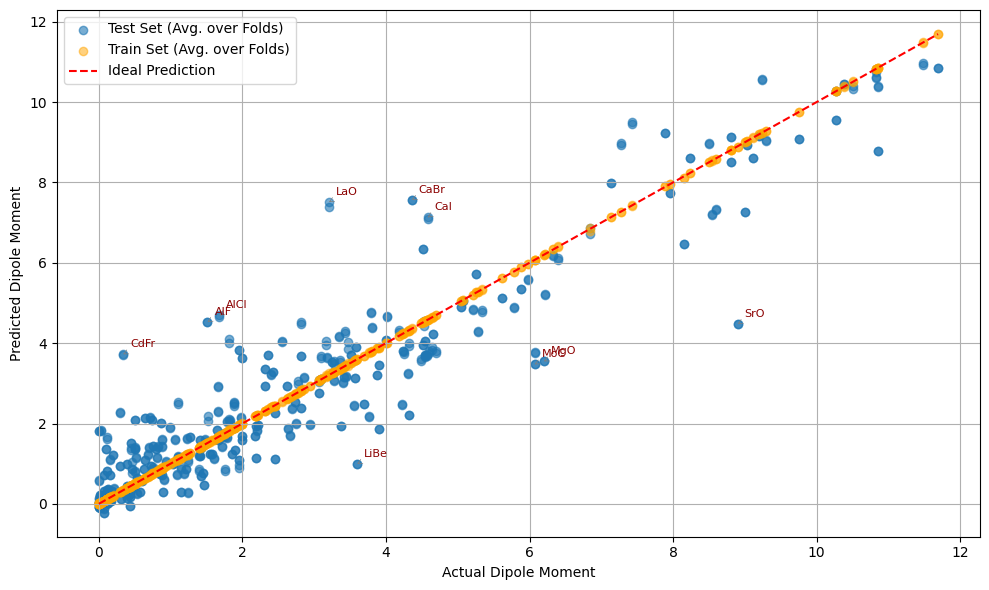

In [3]:

# --- Aggregate predictions to DataFrame ---
def aggregate_predictions(pred_dict, original_y_values):
    actuals, avg_preds, std_preds, indices = [], [], [], []
    for idx in sorted(pred_dict.keys()):
        preds = pred_dict[idx]
        avg_preds.append(np.mean(preds))
        std_preds.append(np.std(preds))
        actuals.append(original_y_values[idx])
        indices.append(idx)
    return pd.DataFrame({
        'index': indices,
        'molecule': [molecules[i] for i in indices],
        'actual': actuals,
        'average_prediction': avg_preds,
        'std_prediction': std_preds
    })

results_df_test = aggregate_predictions(all_predictions_test, y)
results_df_train = aggregate_predictions(all_predictions_train, y)

# --- Compute absolute errors for test set ---
results_df_test['abs_error'] = np.abs(results_df_test['actual'] - results_df_test['average_prediction'])

# --- Plotting ---
plt.figure(figsize=(10, 6))

# Scatter plot test set (no error bars)
plt.scatter(results_df_test['actual'], results_df_test['average_prediction'],
            alpha=0.6, label='Test Set (Avg. over Folds)')

# Scatter plot train set (no error bars)
plt.scatter(results_df_train['actual'], results_df_train['average_prediction'],
            color='orange', alpha=0.5, label='Train Set (Avg. over Folds)')

# Ideal prediction line
min_val = min(results_df_test['actual'].min(), results_df_train['actual'].min())
max_val = max(results_df_test['actual'].max(), results_df_train['actual'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Prediction')

plt.xlabel('Actual Dipole Moment')
plt.ylabel('Predicted Dipole Moment')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Annotate top 10 unique molecules with largest errors in test set
outliers_df = results_df_test.sort_values(by='abs_error', ascending=False)

seen_molecules = set()
labeled_count = 0

for _, row in outliers_df.iterrows():
    mol = row['molecule']
    if mol not in seen_molecules:
        seen_molecules.add(mol)
        plt.annotate(mol,
                     (row['actual'], row['average_prediction']),
                     textcoords="offset points",
                     xytext=(5, 5),
                     ha='left',
                     fontsize=8,
                     color='darkred',
                     arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
        labeled_count += 1
    if labeled_count >= 10:
        break

# Save and show plot
plt.savefig('dipole_moment_prediction_HGB.png')
plt.show()



In [4]:

# ---- Load datasets ----
# ---- Load datasets ----
train_data = pd.read_csv("data.csv")
big_set = pd.read_csv("large_set.csv")

# ---- Feature settings ----
numeric_features = ['ionic_character_4th_root', 'Diff_Ionic','Sum_Affinity','Prod_Ionic_Recip']
categorical_features = ['Group1', 'Group2', 'Period1', 'Period2']
target = 'dipole_moment'

# ---- Column Transformer for preprocessing ----
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

# ---- Prepare features ----
X_train = train_data[numeric_features + categorical_features]
y_train = train_data[target].values.flatten()
X_big = big_set[numeric_features + categorical_features]

# ---- Preprocess data ----
X_train_processed = preprocessor.fit_transform(X_train)
X_big_processed = preprocessor.transform(X_big)

# ---- Train Gradient Boosting Model ----
model = HistGradientBoostingRegressor(max_iter=1000)
model.fit(X_train_processed, y_train)

# ---- Predict on big_set ----
y_big_pred = model.predict(X_big_processed)

# ---- Save results ----
big_set_results = big_set.copy()
big_set_results['predicted_dipole_moment'] = y_big_pred

big_set_results.to_csv("GB_predictions.csv", index=False)
print("Predictions saved to GB_predictions.csv")


Predictions saved to GB_predictions.csv


In [5]:
df1=pd.read_csv("data.csv")
df2=pd.read_csv("GB_predictions.csv")
pairs_df1 = set(tuple(sorted([row['atom 1'], row['atom 2']])) for _, row in df1.iterrows())
mask = df2.apply(lambda row: tuple(sorted([row['Atom 1'], row['Atom 2']])) not in pairs_df1, axis=1)
df2_filtered = df2[mask].reset_index(drop=True)
df2_filtered.to_csv("GB_predictions_no_training.csv",index=False)
